## Modelado 
### Selección del modelo 
La selección de la técnica de modelado es una etapa crucial en el proceso de minería de datos, ya que determina el enfoque y las herramientas que se utilizarán para resolver el problema planteado. En este proyecto, el objetivo principal es clasificar la mortalidad utilizando un conjunto de datos específico. Dado que se trata de un problema de clasificación, las técnicas apropiadas incluyen árboles de decisión, Random Forest, k-nearest neighbor (k-NN), y razonamiento basado en casos (CBR). Se optó inicialmente por los árboles de decisión debido a su simplicidad y capacidad para proporcionar una interpretación clara y visual de las decisiones basadas en los datos. Posteriormente, se eligió Random Forest para mejorar la precisión y robustez del modelo, ya que combina múltiples árboles de decisión y reduce el riesgo de sobreajuste mediante el uso de bagging y selección aleatoria de características. Esta elección está alineada con el objetivo del proyecto y aprovecha las ventajas de las técnicas de minería de datos existentes.

### Generación del plan de prueba
Una vez construido el modelo, es esencial generar un plan de prueba para evaluar su calidad y validez. Este procedimiento incluye la división del conjunto de datos en dos partes: un conjunto de entrenamiento y un conjunto de prueba. El conjunto de entrenamiento se utiliza para construir el modelo, mientras que el conjunto de prueba se emplea para evaluar su rendimiento. En tareas de clasificación supervisada, la razón de error es una medida común de calidad. Se utilizó la matriz de confusión para evaluar la precisión, exactitud y F1-score del modelo. 

## Modelo de árbol de decisión

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from imblearn.combine import SMOTETomek
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Cargar los datos
data = pd.read_csv('data/siniestros-prepared-data.csv', encoding='utf-8', sep=',')


# Separar las características y el objetivo

X = data.drop(['MORTALIDAD'], axis=1)
y = data['MORTALIDAD']
# Aplicar SMOTE + Tomek Links
smote_tomek = SMOTETomek(random_state=42)
X_resampled, y_resampled = smote_tomek.fit_resample(X, y)

# Dividir el conjunto de datos balanceado en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)


# Escalar las características
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Definir el espacio de hiperparámetros para el árbol de decisión
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced']
}

# Configurar GridSearchCV
grid_search = GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), 
                           param_grid=param_grid, 
                           scoring='accuracy', 
                           cv=5, 
                           n_jobs=-1, 
                           verbose=1)

# Ajustar el modelo con GridSearchCV
grid_search.fit(X_train, y_train)

# Obtener los mejores parámetros
best_params = grid_search.best_params_
print(f"Mejores hiperparámetros: {best_params}")

# Obtener el mejor modelo
best_model = grid_search.best_estimator_

# Predicciones
y_pred = best_model.predict(X_test)

# Evaluación del modelo
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print(f"Reporte de clasificación:\n{classification_report(y_test, y_pred)}")
print(f"Matriz de confusión:\n{confusion_matrix(y_test, y_pred)}")


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Mejores hiperparámetros: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Accuracy: 0.8448922863099374
Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.90      0.78      0.83      3588
           1       0.81      0.91      0.85      3607

    accuracy                           0.84      7195
   macro avg       0.85      0.84      0.84      7195
weighted avg       0.85      0.84      0.84      7195

Matriz de confusión:
[[2794  794]
 [ 322 3285]]


Accuracy: 0.8448922863099374
Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.90      0.78      0.83      3588
           1       0.81      0.91      0.85      3607

    accuracy                           0.84      7195
   macro avg       0.85      0.84      0.84      7195
weighted avg       0.85      0.84      0.84      7195

Matriz de confusión:
[[2794  794]
 [ 322 3285]]


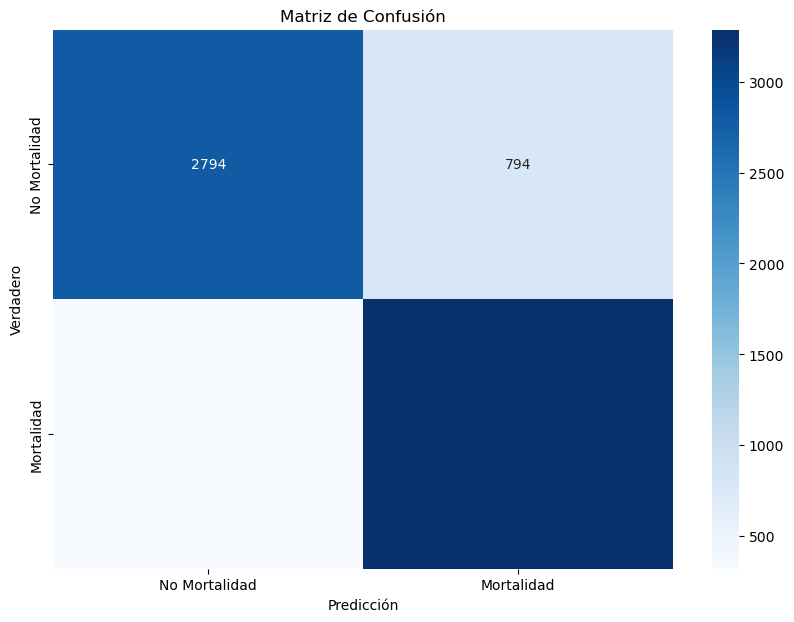

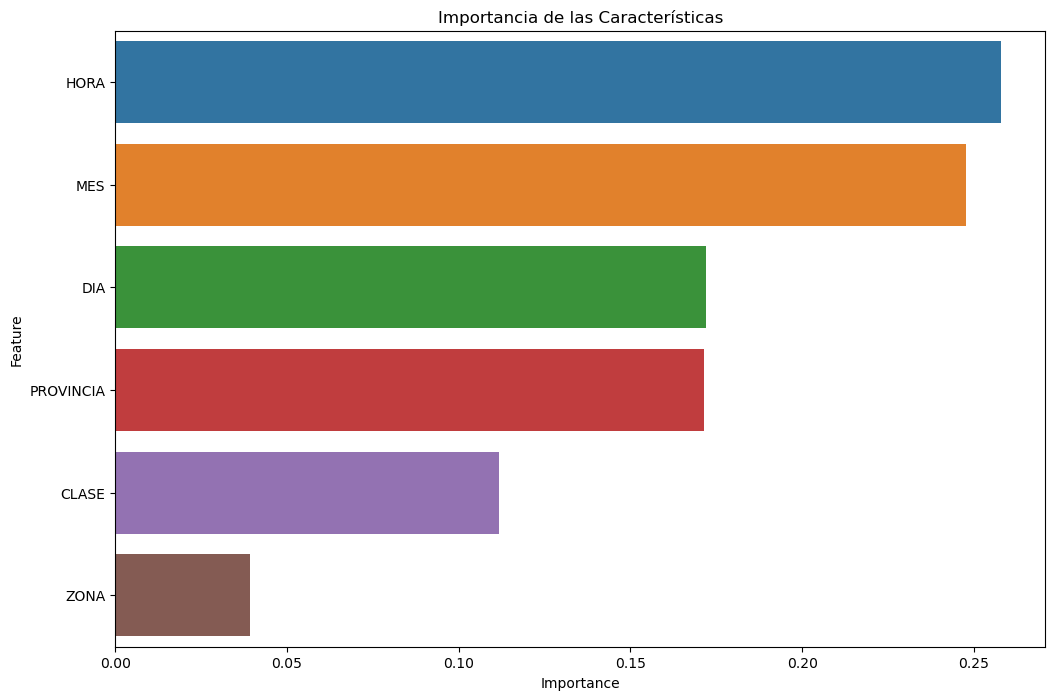

In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pydotplus
from IPython.display import Image


# Definir el modelo con los mejores hiperparámetros
best_model = DecisionTreeClassifier(
    criterion='entropy',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    class_weight='balanced',
    random_state=42
)

# Entrenar el modelo
best_model.fit(X_train, y_train)

# Predicciones
y_pred = best_model.predict(X_test)

# Evaluación del modelo
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print(f"Reporte de clasificación:\n{classification_report(y_test, y_pred)}")
print(f"Matriz de confusión:\n{confusion_matrix(y_test, y_pred)}")

# Graficar la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Mortalidad', 'Mortalidad'], yticklabels=['No Mortalidad', 'Mortalidad'])
plt.xlabel('Predicción')
plt.ylabel('Verdadero')
plt.title('Matriz de Confusión')
plt.show()

# Importancia de las características
feature_importances = best_model.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Graficar la importancia de las características
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Importancia de las Características')
plt.show()



Luego de una prueba rápida con el algoritmo de árboles de decisión, se observó un rendimiento aceptable. Sin embargo, los árboles de decisión pueden tender a sobreajustarse a los datos de entrenamiento, lo que puede resultar en un rendimiento inferior en comparación con técnicas más avanzadas. Por esta razón, se decidió utilizar el algoritmo Random Forest, que combina múltiples árboles de decisión y reduce el riesgo de sobreajuste, con el objetivo de verificar y potencialmente mejorar el rendimiento del modelo.

Accuracy: 0.8765809589993051
Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.90      0.84      0.87      3588
           1       0.85      0.91      0.88      3607

    accuracy                           0.88      7195
   macro avg       0.88      0.88      0.88      7195
weighted avg       0.88      0.88      0.88      7195

Matriz de confusión:
[[3025  563]
 [ 325 3282]]


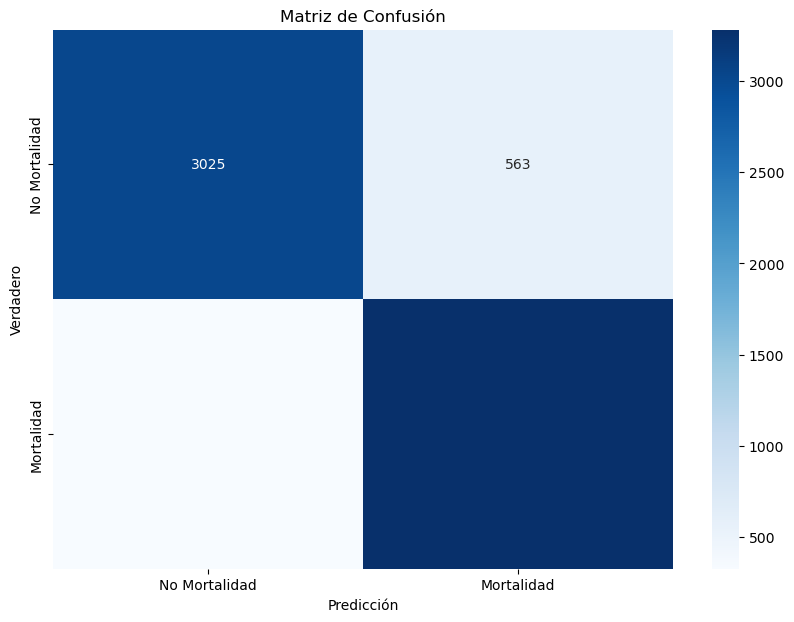

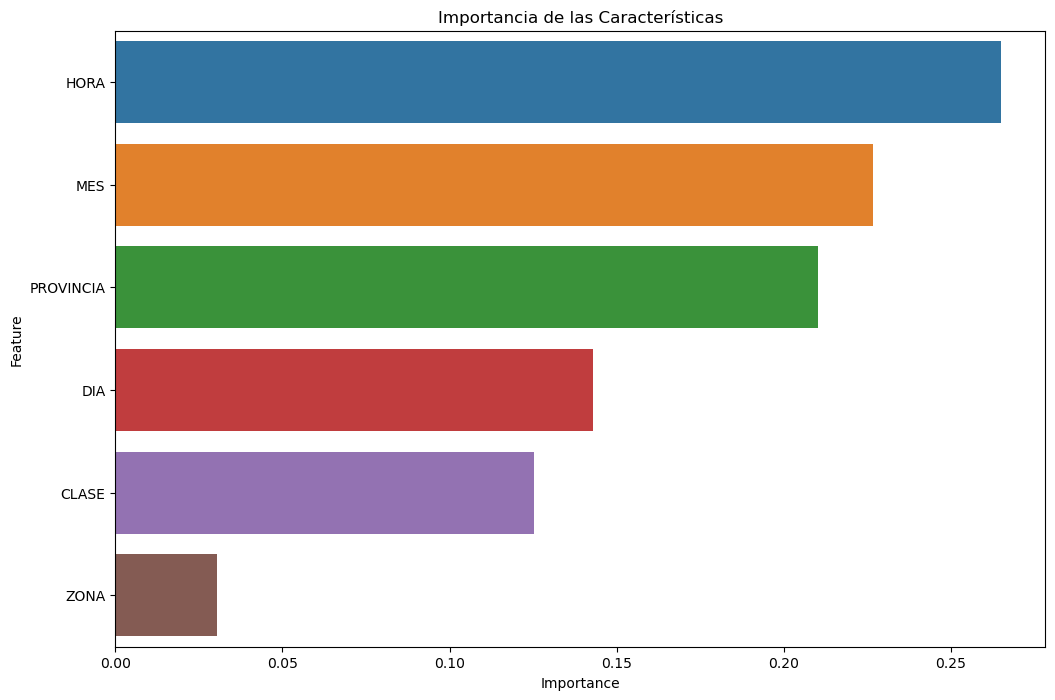

In [6]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler



# Definir el modelo Random Forest
rf_model = RandomForestClassifier(
    n_estimators=100,       # Número de árboles en el bosque
    criterion='entropy',       # Criterio de división de los árboles
    max_depth=None,         # Profundidad máxima de los árboles
    min_samples_split=2,    # Número mínimo de muestras para dividir un nodo
    min_samples_leaf=1,     # Número mínimo de muestras en una hoja
    class_weight='balanced', # Balancear las clases
    random_state=42         # Semilla para reproducibilidad
)


# Entrenar el modelo
rf_model.fit(X_train, y_train)

# Predicciones
y_pred = rf_model.predict(X_test)

# Evaluación del modelo
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print(f"Reporte de clasificación:\n{classification_report(y_test, y_pred)}")
print(f"Matriz de confusión:\n{confusion_matrix(y_test, y_pred)}")

# Graficar la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Mortalidad', 'Mortalidad'], yticklabels=['No Mortalidad', 'Mortalidad'])
plt.xlabel('Predicción')
plt.ylabel('Verdadero')
plt.title('Matriz de Confusión')
plt.show()

# Importancia de las características
feature_importances = rf_model.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Graficar la importancia de las características
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Importancia de las Características')
plt.show()


### Construcción del Modelo
Después de seleccionar la técnica adecuada, se procede a construir el modelo utilizando los datos preparados previamente. Cada técnica de modelado tiene un conjunto de parámetros que influyen en las características del modelo generado. En el caso del Random Forest, parámetros como el número de árboles (n_estimators), el criterio de división (criterion), la profundidad máxima (max_depth), y otros fueron ajustados para optimizar el rendimiento del modelo. La selección de los mejores parámetros es un proceso iterativo que se basa en los resultados obtenidos en cada iteración. Estos resultados deben ser interpretados para justificar el rendimiento del modelo, asegurando que los parámetros seleccionados proporcionan el mejor equilibrio entre precisión y generalización.

Fitting 3 folds for each of 720 candidates, totalling 2160 fits
Mejores parámetros encontrados:  {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 400, 'random_state': 42}
Accuracy: 0.8794996525364837
Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.91      0.84      0.87      3588
           1       0.86      0.91      0.88      3607

    accuracy                           0.88      7195
   macro avg       0.88      0.88      0.88      7195
weighted avg       0.88      0.88      0.88      7195

Matriz de confusión:
[[3030  558]
 [ 309 3298]]


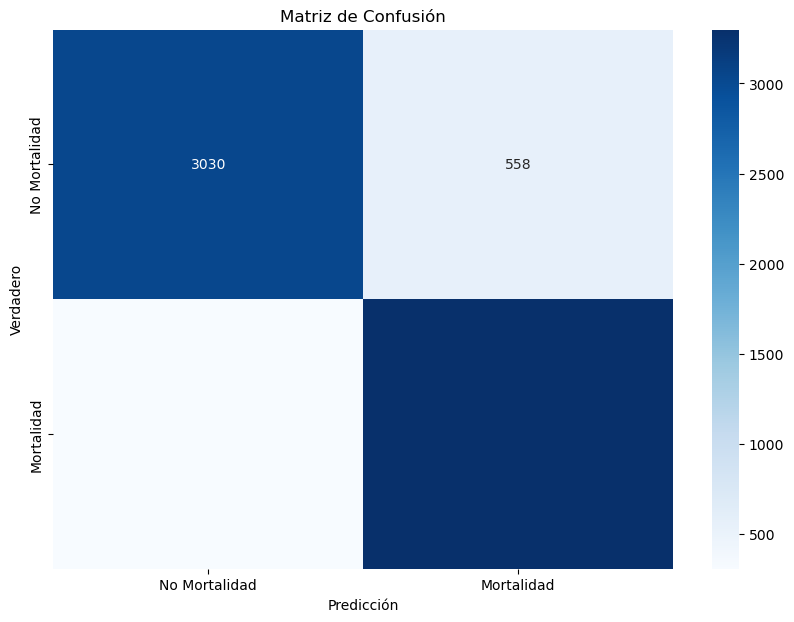

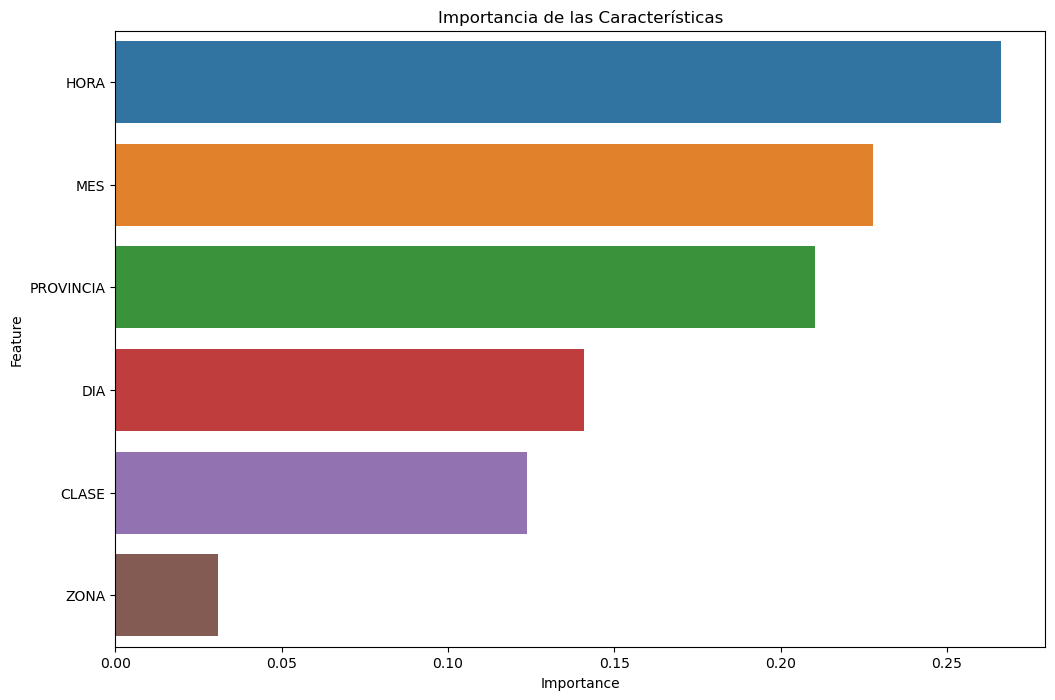

In [9]:
rf_model = RandomForestClassifier(random_state=42)

# Definir el rango de parámetros para la búsqueda en grid
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': [None, 'balanced'],
     'random_state':[42]         # Semilla para reproducibilidad

}

# Realizar la búsqueda en grid
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Imprimir los mejores parámetros encontrados
print("Mejores parámetros encontrados: ", grid_search.best_params_)

# Utilizar el mejor modelo encontrado para hacer predicciones
best_rf_model = grid_search.best_estimator_

# Predicciones
y_pred = best_rf_model.predict(X_test)

# Evaluación del modelo
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print(f"Reporte de clasificación:\n{classification_report(y_test, y_pred)}")
print(f"Matriz de confusión:\n{confusion_matrix(y_test, y_pred)}")

# Graficar la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Mortalidad', 'Mortalidad'], yticklabels=['No Mortalidad', 'Mortalidad'])
plt.xlabel('Predicción')
plt.ylabel('Verdadero')
plt.title('Matriz de Confusión')
plt.show()

# Importancia de las características
feature_importances = best_rf_model.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Graficar la importancia de las características
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Importancia de las Características')
plt.show()

### Evaluación

Accuracy: 0.8794996525364837
Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.91      0.84      0.87      3588
           1       0.86      0.91      0.88      3607

    accuracy                           0.88      7195
   macro avg       0.88      0.88      0.88      7195
weighted avg       0.88      0.88      0.88      7195

Matriz de confusión:
[[3030  558]
 [ 309 3298]]


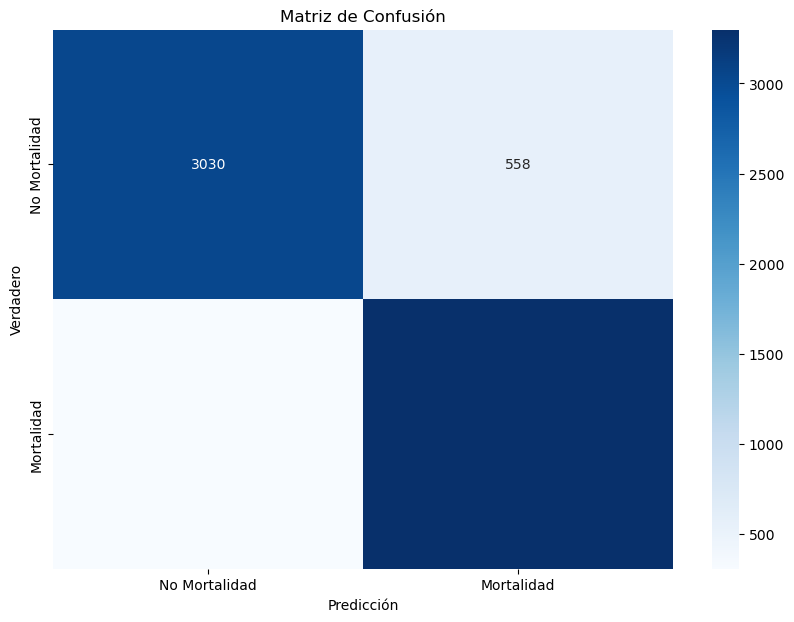

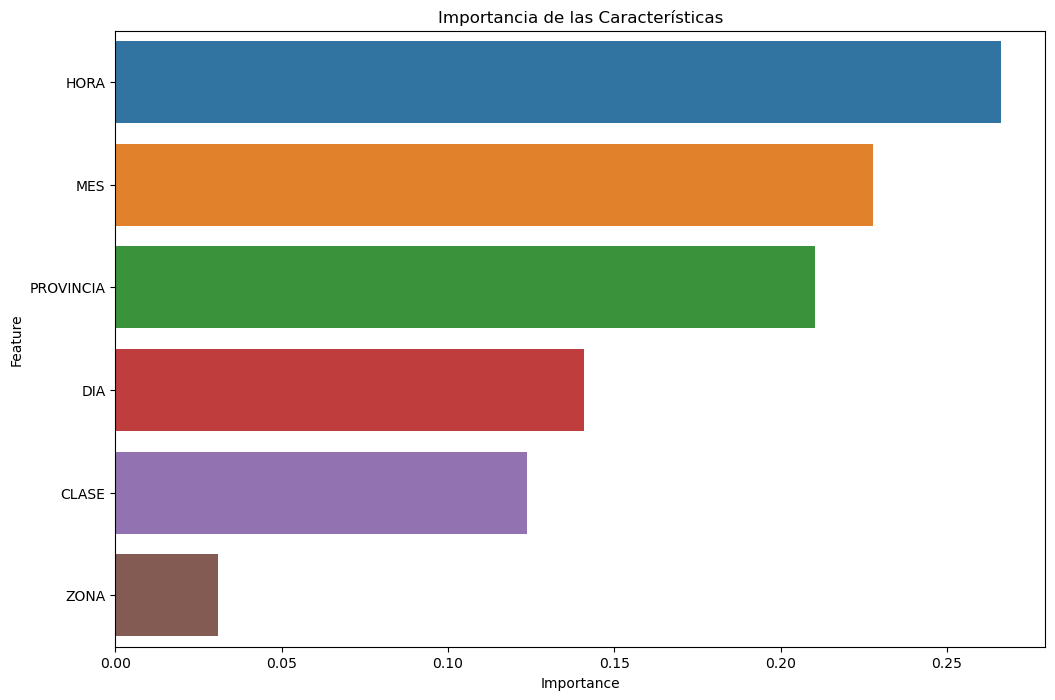

Registros de prueba con predicciones:
     MES  DIA  HORA  PROVINCIA  ZONA  CLASE  Actual  Prediction
0   2.0  5.0   7.0        9.0   1.0    1.0       1           1
1   2.0  7.0   1.0       18.0   2.0    4.0       0           0
2  12.0  6.0   5.0       18.0   1.0    4.0       0           0
3   5.0  5.0  10.0       13.0   2.0    1.0       1           1
4  12.0  5.0  22.0       17.0   1.0    3.0       0           0


In [14]:
params = {
    'n_estimators': 400,
    'criterion': 'entropy',
    'max_depth': None,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'class_weight': 'balanced',
    'random_state': 42
}

# Crear y entrenar el modelo
rf_model = RandomForestClassifier(**params)
rf_model.fit(X_train, y_train)

# Predicciones en el conjunto de prueba
y_pred = rf_model.predict(X_test)

# Evaluación del modelo
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print(f"Reporte de clasificación:\n{classification_report(y_test, y_pred)}")

# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
print(f"Matriz de confusión:\n{conf_matrix}")

# Graficar la matriz de confusión
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Mortalidad', 'Mortalidad'], yticklabels=['No Mortalidad', 'Mortalidad'])
plt.xlabel('Predicción')
plt.ylabel('Verdadero')
plt.title('Matriz de Confusión')
plt.show()

# Importancia de las características
feature_importances = rf_model.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Graficar la importancia de las características
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Importancia de las Características')
plt.show()

X_test_original = scaler.inverse_transform(X_test)
X_test_df = pd.DataFrame(X_test_original, columns=X.columns)
test_samples = X_test_df.head(5)
test_predictions = y_pred[:5]
actual_values = y_test[:5].values

# Crear un DataFrame con los registros de prueba y las predicciones
results_df = test_samples.copy()
results_df['Actual'] = actual_values
results_df['Prediction'] = test_predictions

print("Registros de prueba con predicciones:\n", results_df)


Durante el entrenamiento del modelo con los parámetros óptimos, se evaluaron varias métricas importantes, como la precisión, el accuracy, el F1-score y la matriz de confusión. Los resultados obtenidos fueron prometedores, indicando que el modelo es capaz de predecir la mortalidad en accidentes de tráfico de manera efectiva. Los datos utilizados incluyeron parámetros clave como la clase del accidente, provincia, y hora, lo cual proporcionó una base sólida para las predicciones.

La precisión del modelo para la clase 0 fue de 0.91 y para la clase 1 fue de 0.86, lo que indica que el modelo tiene una alta capacidad para identificar correctamente los casos positivos y negativos. El recall fue de 0.84 para la clase 0 y de 0.91 para la clase 1, demostrando que el modelo puede recuperar la mayoría de las instancias relevantes para cada clase. El F1-score, que es una medida que combina la precisión y el recall, fue de 0.87 para la clase 0 y de 0.88 para la clase 1, lo cual sugiere un buen equilibrio entre estas dos métricas.

La matriz de confusión reflejó un alto número de predicciones correctas, con pocas instancias mal clasificadas. En términos de accuracy, el modelo alcanzó un 87.95%, lo que muestra una elevada precisión general en las predicciones. Estos resultados fueron corroborados con registros de prueba específicos, donde las predicciones del modelo coincidieron con las observaciones reales, confirmando la fiabilidad del modelo.

En resumen, el modelo desarrollado ha demostrado ser robusto y preciso en la predicción de la mortalidad en accidentes de tráfico. Las métricas evaluadas y los resultados obtenidos subrayan su capacidad para realizar predicciones precisas y fiables, proporcionando una herramienta valiosa para la toma de decisiones basadas en datos en el ámbito de la seguridad vial.






